In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
from datetime import datetime
from helpers import *
from einops import rearrange
import random

if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")


Using MPS


# Hyperparameters

In [3]:
seq_size = 30 # number of previous days used to predict next day
test_start_date = pd.to_datetime("2023-01-01")
train_start_date = pd.to_datetime("2020-01-01")
out_cols = ['pct_change']
epochs = 25
batch_size = 32
d_model = 128 # number of input features to encoder layer
nhead = 32 # number of heads in multiheadattention
num_layers = 64 # number of encoder layers
dropout = 0.1 # dropout probability

# loading data
data_path = 'data'
interval = '1d'
companies = os.listdir(data_path)
companies = random.sample(companies, 5)
# companies = ['AAPL', 'GOOGL', 'NVDA', ]
for c in companies:
    if c == 'constituents.csv':
        companies.remove(c)
    elif c == '.DS_Store':
        companies.remove('.DS_Store')

# make unique number for each company ticker
ids = np.linspace(0, 1, len(companies)).round(5)

# Loading Data

In [4]:
def load_data(
    companies: list[str],
    ids: np.array,
    data_path: str,
    interval: str,
    train_start_date: pd.Timestamp,
    test_start_date: pd.Timestamp,
    out_cols: list[str],
    seq_size: int,
):
    """
    Function to load data from csv files in company folders

    Inputs
        companies: list of company tickers for data to be loaded
        ids: array of floats for each company ticker
        data_path: path where comapany folders are located
        interval: frequency of stock price data (1d, 1h, etc)
        train_start_date: first date to include in training data
        test_start_date: first test date to include in testing data
        out_cols: names of columns that the model will predict
        seq_size: number of datapoints in each sequence before prediction

    Outputs
        train_loader: training set dataloader for model
        test_loader: test set dataloader for model
        indims: number of input dimensions for model
        outdims: number of output dimensions for model
        dates: test set prediction dates
        company_stats: dictionary where the keys are the ticker and values are that company's stat dict (see z_norm documentation)
        num_to_ticker: dictionary where the keys are the unique number from ids and values are respective ticker
        ticker_to_num: dictionary where the keys are the company ticker and the values are the unique number for that ticker
        feature_cols_idx: index of output feature columns for use in training (since number of columns in y must be equal to number of columns in x in TensorDataset)
    """

    company_stats = dict()  # keys are ticker, values are that company's stat dict
    num_to_ticker = dict()
    ticker_to_num = dict()
    for i, num in enumerate(ids):
        num_to_ticker[str(num)] = companies[i]
        ticker_to_num[companies[i]] = num

    x_train = []
    x_test = []
    y_train = []
    y_test = []
    dates = []

    for co in tqdm(companies):
        files = os.listdir(os.path.join(data_path, co))
        for f in files:  # check each company folder for specific interval of data
            if interval in f:
                file = f

        df = pd.read_csv(os.path.join(data_path, co, file))
        df["date"] = pd.to_datetime(df["date"])
        # remove blank column
        df = df.drop(columns=["Unnamed: 0"])
        # remove data before training start date
        df = df[df["date"] >= train_start_date]

        # normalize columns, excluding date column
        df_normed, stat_dict = z_norm(df, ["date", 'pct_change'])
        # add ticker column
        df_normed["ticker"] = ticker_to_num[co]

        cols = list(df_normed.columns)
        cols.append(
            cols.pop(cols.index("date"))
        )  # move date to end of list since this will be the order of columns for output df

        # get index of test start date
        test_start_idx = np.min(np.argmax(df_normed["date"] >= test_start_date))

        # get dates for test data
        pred_dates = df_normed["date"].iloc[test_start_idx + seq_size :].tolist()
        dates.append(pred_dates)

        # drop date column before making sequences
        df_normed = df_normed.drop(columns=["date"])

        # store column indices for extracting output features we want
        feature_cols_idx = [
            list(df_normed.columns).index(feature) for feature in out_cols
        ]

        # convert to 2D numpy array of shape (-1, num_cols)
        data_arr = df_normed.to_numpy()

        # convert to sequences and append to respective training and testing lists
        x, y = to_sequences(seq_size, data_arr)
        for i in range(len(x)):
            if i < test_start_idx - seq_size:
                x_train.append(x[i])
                y_train.append(y[i])
            else:
                x_test.append(x[i])
                y_test.append(y[i])

        company_stats[co] = stat_dict

    indims = y_train[0].shape[0]
    outdims = len(out_cols)
    dates = [element for nestedlist in dates for element in nestedlist]

    x_train = np.vstack(x_train).reshape(-1, seq_size, indims)
    y_train = np.vstack(y_train).reshape(-1, indims)
    x_test = np.vstack(x_test).reshape(-1, seq_size, indims)
    y_test = np.vstack(y_test).reshape(-1, indims)

    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
    )

    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )

    return (
        train_loader,
        test_loader,
        indims,
        outdims,
        dates,
        company_stats,
        num_to_ticker,
        ticker_to_num,
        feature_cols_idx,
    )


(
    train_loader,
    test_loader,
    indims,
    outdims,
    dates,
    company_stats,
    num_to_ticker,
    ticker_to_num,
    feature_cols_idx,
) = load_data(
    companies,
    ids,
    data_path,
    interval,
    train_start_date,
    test_start_date,
    out_cols,
    seq_size,
)

100%|██████████| 5/5 [00:00<00:00, 46.09it/s]


In [5]:
x, y = next(iter(test_loader))

In [19]:
x.shape

torch.Size([32, 30, 20])

In [20]:
y.shape

torch.Size([32, 20])

Using basic transformer from https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_10_3_transformer_timeseries.ipynb

In [10]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, output_dim)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x
    

class BigTransformer(nn.Module):
    def __init__(self, indim, outdim, hidden_dim=256, d_model=64, nhead=4, num_encoder_layers=6, num_decoder_layers=6):
        super(BigTransformer, self).__init__()

        self.pos_encoder = PositionalEncoding(d_model)
        self.embedding = nn.Sequential(
            nn.Linear(indim, hidden_dim),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, d_model)
            )
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, batch_first=True)

        self.decoder_mlp = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, outdim)
        )

        self.d_model = d_model

    def forward(self, src):
        tgt = src[:,0,:].unsqueeze(1)
        src = self.embedding(src)
        src = self.pos_encoder(src)
        tgt = self.embedding(tgt)
        tgt = self.pos_encoder(tgt)
        src_mask = nn.Transformer.generate_square_subsequent_mask(len(src)).to(device)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(len(tgt)).to(device)
        out = self.transformer(src, tgt, src_mask, tgt_mask, src_is_causal=True, tgt_is_causal=True)
        out = self.decoder_mlp(out)
        return out.squeeze(1)


# model = TransformerModel(input_dim=indims, output_dim=outdims, d_model=d_model, nhead=nhead, num_layers=num_layers, dropout=dropout).to(device)
model = BigTransformer(indims, outdims, 256, d_model, nhead, num_encoder_layers=6, num_decoder_layers=6).to(device)

In [12]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

early_stop_count = 0
min_val_loss = float('inf')

for epoch in tqdm(range(epochs)):
    model.train()
    train_losses = []
    for batch in train_loader:
        x_batch, y_batch = batch
        y_batch = y_batch[:, feature_cols_idx]
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            y_batch = y_batch[:, feature_cols_idx]
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    train_loss = np.mean(train_losses)
    
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

  4%|▍         | 1/25 [00:21<08:31, 21.32s/it]

Epoch 1/25, Train Loss: 0.0073, Validation Loss: 0.0004


  8%|▊         | 2/25 [00:39<07:29, 19.56s/it]

Epoch 2/25, Train Loss: 0.0011, Validation Loss: 0.0006


 12%|█▏        | 3/25 [00:59<07:13, 19.71s/it]

Epoch 3/25, Train Loss: 0.0010, Validation Loss: 0.0004


 16%|█▌        | 4/25 [01:18<06:45, 19.31s/it]

Epoch 4/25, Train Loss: 0.0010, Validation Loss: 0.0005


 20%|██        | 5/25 [01:37<06:26, 19.31s/it]

Epoch 5/25, Train Loss: 0.0010, Validation Loss: 0.0004


 24%|██▍       | 6/25 [01:56<06:01, 19.04s/it]

Epoch 6/25, Train Loss: 0.0010, Validation Loss: 0.0004


 28%|██▊       | 7/25 [02:14<05:41, 18.97s/it]

Epoch 7/25, Train Loss: 0.0010, Validation Loss: 0.0004


 32%|███▏      | 8/25 [02:33<05:22, 18.95s/it]

Epoch 8/25, Train Loss: 0.0010, Validation Loss: 0.0004


 36%|███▌      | 9/25 [02:52<05:02, 18.91s/it]

Epoch 9/25, Train Loss: 0.0010, Validation Loss: 0.0004


 40%|████      | 10/25 [03:12<04:50, 19.36s/it]

Epoch 10/25, Train Loss: 0.0010, Validation Loss: 0.0004


 44%|████▍     | 11/25 [03:30<04:24, 18.88s/it]

Epoch 11/25, Train Loss: 0.0010, Validation Loss: 0.0004


 48%|████▊     | 12/25 [03:48<03:59, 18.45s/it]

Epoch 12/25, Train Loss: 0.0010, Validation Loss: 0.0004


 52%|█████▏    | 13/25 [04:05<03:37, 18.16s/it]

Epoch 13/25, Train Loss: 0.0010, Validation Loss: 0.0004


 56%|█████▌    | 14/25 [04:23<03:19, 18.17s/it]

Epoch 14/25, Train Loss: 0.0010, Validation Loss: 0.0004


 60%|██████    | 15/25 [04:41<02:59, 17.98s/it]

Epoch 15/25, Train Loss: 0.0010, Validation Loss: 0.0004


 64%|██████▍   | 16/25 [04:58<02:40, 17.84s/it]

Epoch 16/25, Train Loss: 0.0010, Validation Loss: 0.0004


 68%|██████▊   | 17/25 [05:16<02:22, 17.83s/it]

Epoch 17/25, Train Loss: 0.0010, Validation Loss: 0.0004


 72%|███████▏  | 18/25 [05:37<02:11, 18.84s/it]

Epoch 18/25, Train Loss: 0.0010, Validation Loss: 0.0004


 76%|███████▌  | 19/25 [05:58<01:56, 19.49s/it]

Epoch 19/25, Train Loss: 0.0010, Validation Loss: 0.0004


 80%|████████  | 20/25 [06:17<01:35, 19.06s/it]

Epoch 20/25, Train Loss: 0.0010, Validation Loss: 0.0004


 84%|████████▍ | 21/25 [06:34<01:14, 18.72s/it]

Epoch 21/25, Train Loss: 0.0010, Validation Loss: 0.0004


 88%|████████▊ | 22/25 [06:53<00:55, 18.61s/it]

Epoch 22/25, Train Loss: 0.0010, Validation Loss: 0.0004


 92%|█████████▏| 23/25 [07:11<00:37, 18.53s/it]

Epoch 23/25, Train Loss: 0.0010, Validation Loss: 0.0004


 96%|█████████▌| 24/25 [07:30<00:18, 18.60s/it]

Epoch 24/25, Train Loss: 0.0010, Validation Loss: 0.0004


100%|██████████| 25/25 [07:48<00:00, 18.75s/it]

Epoch 25/25, Train Loss: 0.0010, Validation Loss: 0.0004


In [ ]:
saved_weights_path = 'saved_models'
fn = f'AAPL_model_{datetime.now().strftime("%Y%m%d")}.pt'

In [ ]:
torch.save(model.state_dict(), os.path.join(saved_weights_path, fn))

# Testing

In [14]:
# testing with metrics
# model = TransformerModel(input_dim=indims, output_dim=outdims).to(device)
# model.load_state_dict(torch.load(os.path.join(saved_weights_path, "AAPL_model_20240209.pt")))
results = []
gt_preds = []
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader)):
        x_batch, y_batch = batch
        tickers = [num_to_ticker[str(y_batch.detach().numpy()[idx,-1])] for idx in range(y_batch.shape[0])]
        y_batch = y_batch[:, feature_cols_idx]
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch).squeeze(1)

        gt_outputs = process_results(y_batch, batch_size, i, dates, tickers)
        processed_outputs = process_results(torch.sigmoid(outputs), batch_size, i, dates, tickers)

        [results.append(out) for out in processed_outputs]
        [gt_preds.append(out) for out in gt_outputs]

columns = [ele for nested in [out_cols, ['ticker', 'date']] for ele in nested]
df_pred = pd.DataFrame(results, columns=columns)
df_gt = pd.DataFrame(gt_preds, columns=columns)
for co in companies:
#     df_pred[df_pred['ticker'] == co] = reverse_z_norm(df_pred, company_stats[co], col_exclude=['ticker', 'date'])
    df_gt[df_pred['ticker'] == co] = reverse_z_norm(df_gt, company_stats[co], col_exclude=['ticker', 'date', 'pct_change'])

df_pred = rename_cols(df_pred, '_pred', ['date', 'ticker'])
df_gt = rename_cols(df_gt, '_gt', ['date', 'ticker'])
df_merged = pd.merge(df_pred, df_gt, 'inner')

0it [00:44, ?it/s]


KeyboardInterrupt: 

In [11]:
df_merged.head()

,pct_change_pred,ticker,date,pct_change_gt
0,0.498258,AAPL,2023-02-15,0.013903
1,0.498259,AAPL,2023-02-16,-0.010429
2,0.498259,AAPL,2023-02-17,-0.007547
3,0.498258,AAPL,2023-02-21,-0.026680
4,0.498258,AAPL,2023-02-22,0.002896


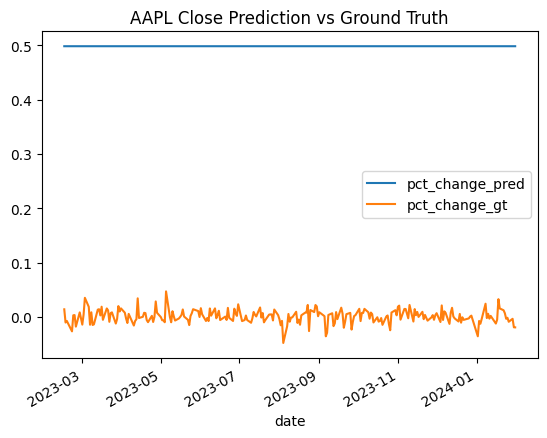

In [12]:
df_merged[df_merged['ticker'] == 'AAPL'].plot(x='date', y=['pct_change_pred', 'pct_change_gt'])
plt.legend()
plt.title(f"AAPL Close Prediction vs Ground Truth")
plt.show()

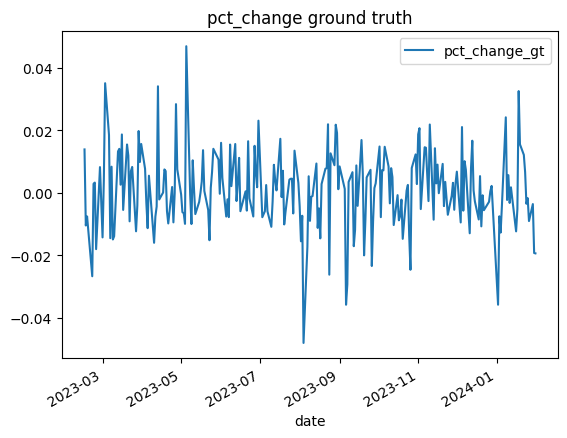

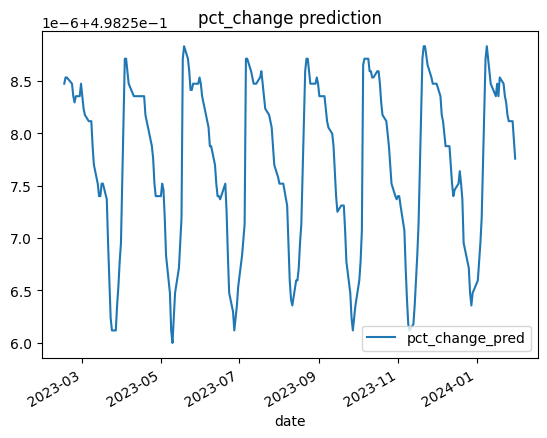

In [13]:
df_merged[df_merged['ticker'] == 'AAPL'].plot(x='date', y='pct_change_gt')
plt.title("pct_change ground truth")
plt.show()
df_merged[df_merged['ticker'] == 'AAPL'].plot(x='date', y='pct_change_pred')
plt.title("pct_change prediction")
plt.show()

In [14]:
accuracy_metrics = dict()
for i in range(len(companies)):
    accuracy_metrics[companies[i]] = dict()
    gt_rows = df_merged[df_merged["ticker"] == companies[i]]["pct_change_gt"]
    pred_rows = df_merged[df_merged["ticker"] == companies[i]]["pct_change_pred"]
    da = directional_accuracy_pct_change(gt_rows, pred_rows)
    pct_increasing = (gt_rows >= 0).sum()/len(gt_rows)
    accuracy_metrics[companies[i]]["directional accuracy"] = da
    accuracy_metrics[companies[i]]["pct increasing"] = pct_increasing
    accuracy_metrics[companies[i]]["pred vs gt DA difference"] = da - pct_increasing

    print(f"{companies[i]} DA improvement over buy and hold: {accuracy_metrics[companies[i]]['pred vs gt DA difference']:.4f}")


AAPL DA improvement over buy and hold: -0.0041


In [12]:
accuracy_metrics

{'AAPL': 0.5269709543568465}